In [1]:
import sys
from pathlib import Path

# Add the src directory to sys.path
root_dir = Path().absolute().parent.parent
# Add project root to the path of Python
sys.path.append(str(root_dir))

from src import config  # noqa: E402

settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import json
import os
import warnings
from datetime import datetime

import hopsworks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance

from src.utils import util

warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ["HOPSWORKS_API_KEY"] = api_key
project = hopsworks.login()
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country = location["country"]
city = location["city"]
street = location["street"]

2025-05-18 12:16:16,519 INFO: Initializing external client
2025-05-18 12:16:16,519 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-18 12:16:18,151 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1224891


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name="air_quality",
    version=1,
)
weather_fg = fs.get_feature_group(
    name="weather",
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(["pm25"]).join(
    weather_fg.select_all(include_primary_key=False), on=["city"]
)

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_fv",
    description="weather features with air quality as the target",
    version=1,
    labels=["pm25"],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
start_date_test_data = "2025-3-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_start=test_start)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 


In [9]:
X_train.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2019-12-15 00:00:00+00:00,18.322668,8.9,6.618519,48.224552
1,2019-12-16 00:00:00+00:00,19.126833,6.3,9.360000,76.253380
2,2019-12-17 00:00:00+00:00,18.935167,5.4,8.049845,71.833992
3,2019-12-18 00:00:00+00:00,19.218500,2.2,7.235910,352.234863
4,2019-12-19 00:00:00+00:00,19.410166,0.6,8.287822,64.303047


In [10]:
X_test.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
1874,2025-03-15 00:00:00+00:00,19.395584,2.100000,6.120000,291.721069
1875,2025-03-18 00:00:00+00:00,18.591417,14.800001,5.393997,91.347855
1876,2025-03-19 00:00:00+00:00,19.731001,1.400000,7.636753,75.963669
1877,2025-03-20 00:00:00+00:00,19.733084,7.500000,8.117980,85.350662
1878,2025-03-21 00:00:00+00:00,20.495584,1.200000,7.510552,72.758430


In [11]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(["date"], axis=1)
test_features = X_test.drop(["date"], axis=1)

In [12]:
y_train.head()

,pm25
0,62.0
1,57.0
2,59.0
3,70.0
4,73.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:, 0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:, 0], y_pred)
print("R squared:", r2)

MSE: 195.45301818847656
R squared: -0.9899337291717529


In [15]:
df = y_test
df["predicted_pm25"] = y_pred

In [16]:
df["date"] = X_test["date"]
df = df.sort_values(by=["date"])
df.head(5)

,pm25,predicted_pm25,date
1874,60.0,53.039104,2025-03-15 00:00:00+00:00
1875,72.0,45.396469,2025-03-18 00:00:00+00:00
1876,62.0,59.146465,2025-03-19 00:00:00+00:00
1877,50.0,53.978088,2025-03-20 00:00:00+00:00
1878,53.0,58.938721,2025-03-21 00:00:00+00:00


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

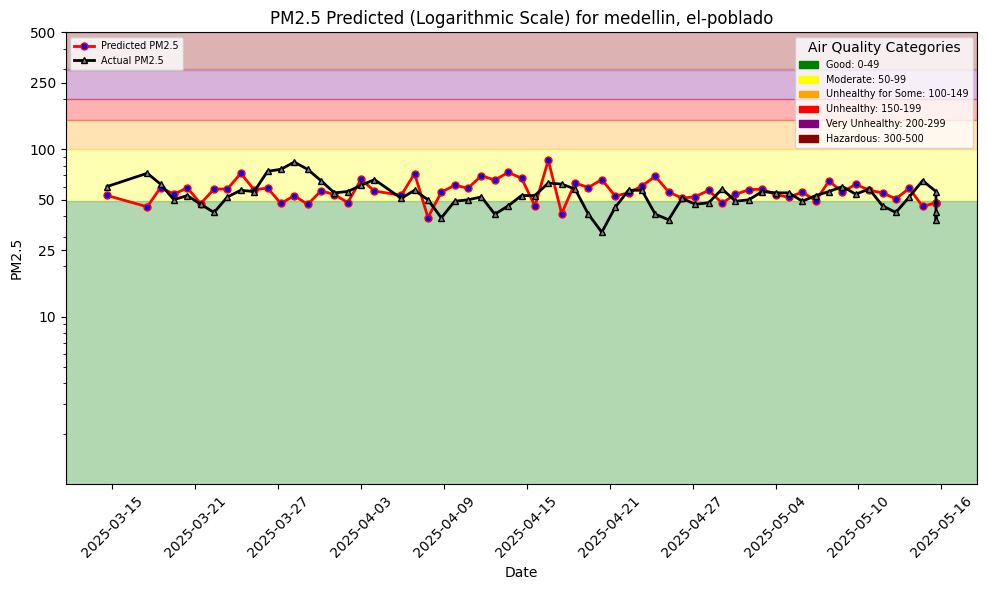

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
figure = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True)
figure.show()

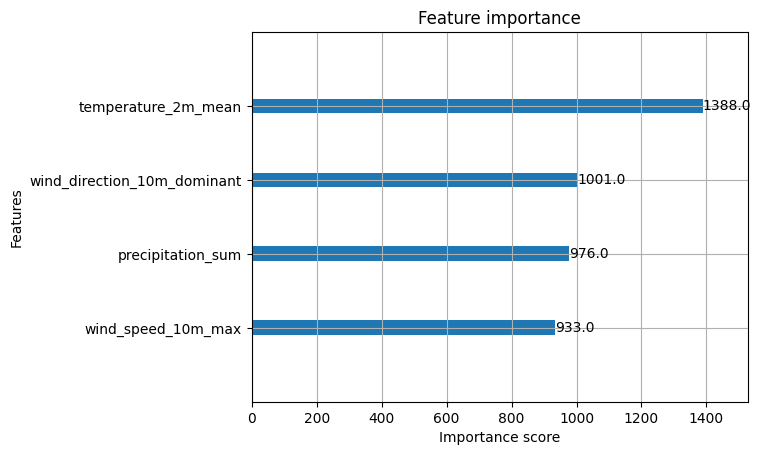

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [20]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [21]:
res_dict = {
    "MSE": str(mse),
    "R squared": str(r2),
}

In [22]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model",
    metrics=res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /media/joser/Datos/Github/air-quality-fti/notebooks/5-models/air_quality_model/model.json: 0.000%|  …

Uploading /media/joser/Datos/Github/air-quality-fti/notebooks/5-models/air_quality_model/images/feature_import…

Uploading /media/joser/Datos/Github/air-quality-fti/notebooks/5-models/air_quality_model/images/pm25_hindcast.…

Uploading /media/joser/Datos/Github/air-quality-fti/notebooks/5-models/model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1224891/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
